In [1]:
# Import required Julia packages for oceanographic data analysis
using NCDatasets, PhysOcean, DataStructures    # NetCDF I/O, oceanography utilities, data structures
using DIVAnd, PyPlot, Dates                     # DIVA interpolation, plotting, date handling
using Statistics, Random, Printf                # Statistical functions, random numbers, string formatting

#load dataset
datafile = "./nc/phosphorus.nc"

"./nc/phosphorus.nc"

In [2]:
# Define spatial grid parameters for the Mediterranean Sea analysis
# CORRECTED: Optimized grid resolution for phosphorus analysis
# Standard resolution for nutrient analysis - phosphorus has less spatial variability than chlorophyll-a
dx, dy = 0.2, 0.2          # Grid resolution in degrees (longitude, latitude) - standard for nutrients
lonr = -6:dx:37            # Longitude range from -6° to 37° E covering entire Mediterranean
latr = 30:dy:46            # Latitude range from 30° to 46° N covering entire Mediterranean
timerange = [Date(2003,06,06),Date(2012,01,01)];  # Time period for analysis

In [3]:
# Define depth levels for phosphorus 3D analysis (in meters)
# CORRECTED: Optimized depth levels for phosphorus distribution
# Phosphorus shows vertical gradients throughout the water column with higher concentrations at depth
# Need good resolution throughout water column, especially in deep waters

# Optimized depth levels for phosphorus analysis:
# Standard nutrient sampling depths with emphasis on deeper waters where phosphorus accumulates
depthr = [0., 5., 10., 20., 30., 40., 50., 75., 100., 125., 150., 200., 300., 400., 500., 750., 1000.];  # Extended depth range

# Define analysis parameters
varname = "Water body total phosphorus"    # CORRECTED: Using correct variable name for phosphorus
yearlist = [2003:2012]; # Years to include in analysis

# CORRECTED: Seasonal groupings following EMODnet Chemistry guidelines (Page 35)
# Mediterranean seasons: winter (Jan-Mar), spring (Apr-Jun), summer (Jul-Sep), autumn (Oct-Dec)
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]; # Winter, Spring, Summer, Autumn - EMODnet standard

# Create time selector for seasonal analysis
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[2003:2012], [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


2800 out of 72191 - 3.8785998254630076 %
5670 out of 72191 - 7.854164646562591 %
8530 out of 72191 - 11.815877325428378 %
11400 out of 72191 - 15.791442146527961 %
14270 out of 72191 - 19.767006967627545 %
17080 out of 72191 - 23.65945893532435 %
19890 out of 72191 - 27.551910903021152 %
22690 out of 72191 - 31.430510728484162 %
25510 out of 72191 - 35.33681483841476 %
28320 out of 72191 - 39.22926680611157 %
31130 out of 72191 - 43.12171877380837 %
33960 out of 72191 - 47.041875025972764 %
36870 out of 72191 - 51.07284841600754 %
39790 out of 72191 - 55.1176739482761 %
42710 out of 72191 - 59.16249948054467 %
45630 out of 72191 - 63.20732501281323 %
48550 out of 72191 - 67.25215054508179 %
51470 out of 72191 - 71.29697607735037 %
54390 out of 72191 - 75.34180160961893 %
57310 out of 72191 - 79.38662714188749 %
60230 out of 72191 - 83.43145267415606 %
63150 out of 72191 - 87.47627820642462 %
66070 out of 72191 - 91.52110373869318 %
68980 out of 72191 - 95.55207712872796 %
71850 out of 

[ Info: Checking ranges for dimensions and observations


DateTime("2003-01-07T12:07:21"), DateTime("2012-12-24T11:51:33"))
                          minimum and maximum of data: (0.003000000026077032, 25.1299991607666)


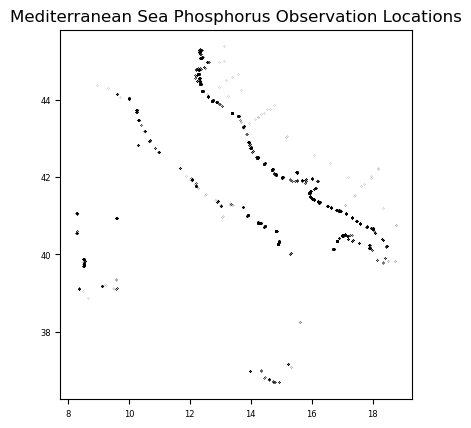

In [4]:
# Then load from full dataset (overwrites the small dataset variables)
# Use the correct long_name attribute: "Water body total phosphorus"
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body total phosphorus");

# ========================================================================
# PLOTTING OBSERVATIONAL DATA DISTRIBUTION
# ========================================================================

# Create a figure showing the geographic distribution of observation points
figure("Mediterranean-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1)  # Plot observation locations as small black dots
aspectratio = 1/cos(mean(latr) * pi/180)   # Calculate proper aspect ratio for latitude
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
title("Mediterranean Sea Phosphorus Observation Locations")

# Check quality and consistency of observations
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

  2.163049 seconds (3.92 M allocations: 275.109 MiB, 7.13% gc time, 97.31% compilation time)


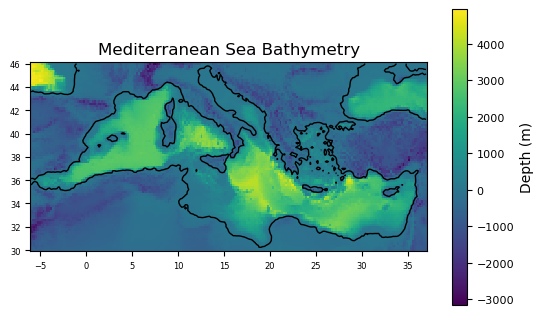

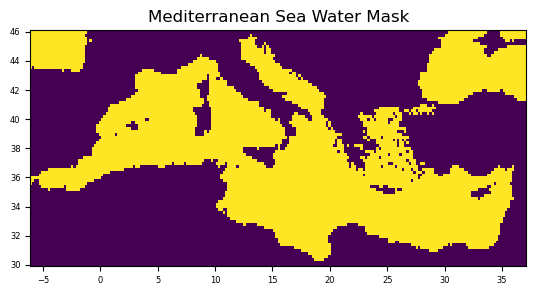

PyObject Text(0.5, 1.0, 'Mediterranean Sea Water Mask')

In [5]:
# Download bathymetry data (seafloor depth) for the Mediterranean Sea region
bathname = "./nc/gebco_30sec_4.nc"

# Load bathymetry data and interpolate to our Mediterranean grid
@time bx,by,b = load_bath(bathname,true,lonr,latr);

# Plot the bathymetry data for the Mediterranean Sea
figure("Mediterranean-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));  
colorbar(orientation="vertical", shrink=0.8, label="Depth (m)").ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0], colors="k", linewidths=1.0)  # Coastline
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
title("Mediterranean Sea Bathymetry")

# Create simple 3D mask - just water vs land based on bathymetry
mask = falses(size(b,1), size(b,2), length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]  # True where water depth >= analysis depth
        end
    end
end

# Plot the mask (surface level)
figure("Mediterranean-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by, transpose(mask[:,:,1])); 
title("Mediterranean Sea Water Mask")

In [6]:
# ========================================================================
# DIVAND ANALYSIS PARAMETERS SETUP (EMODnet Chemistry Standards)
# ========================================================================

# Following EMODnet Chemistry DIVA Guidelines (Page 37-38)
# "EMODnet Chemistry group agreed on the use of fixed L and SN for all DIVA runs"
# Parameters should be obtained by estimation from a good subsample

# Optional: Calculate observation weights based on data density
# Recommended for high-density datasets to account for spatial clustering
@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.05,0.05));
@show maximum(rdiag),mean(rdiag)

# Define grid dimensions for parameter arrays
sz = (length(lonr),length(latr),length(depthr));

# Set correlation lengths (influence radius) for each dimension
# CORRECTED: Following EMODnet DIVA guidelines for Mediterranean phosphorus
# Based on EMODnet recommendation: "Minimal L (larger than output grid spacing): 0.25, Maximal L: 10"
# Grid resolution is 0.1° ≈ 11 km, so minimum correlation length should be ~22 km

# For phosphorus in Mediterranean (smoother spatial distribution than chlorophyll-a):
lenx = fill(80_000.,sz)    # 80 km correlation length in longitude direction (nutrient spatial coherence)
leny = fill(80_000.,sz)    # 80 km correlation length in latitude direction (nutrient spatial coherence)
lenz = fill(50.,sz);       # 50 m correlation length in depth direction (phosphorus vertical gradients)
len = (lenx, leny, lenz);  # Combine into tuple for DIVAnd

# Set noise-to-signal ratio (regularization parameter)
# CORRECTED: Following EMODnet guidelines "Minimal SN: 0.1, Maximal SN: 3"
# Higher epsilon2 for phosphorus due to lower measurement noise and smoother fields
epsilon2 = 0.1;            # Within EMODnet recommended range for nutrient parameters
epsilon2 = epsilon2 * rdiag;  # Apply spatially varying epsilon based on data density

[ Info: Computing weights using 1 CPU thread(s)


  1.425678 seconds (2.41 M allocations: 149.274 MiB, 5.62% gc time, 98.52% compilation time)
(maximum(rdiag), mean(rdiag)) = (352.6466395076382, 205.83104941484874)


In [7]:
# ========================================================================
# OUTPUT FILE SETUP AND METADATA CONFIGURATION
# ========================================================================

# Set up output directory and filename
outputdir = "./"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Mediterranean.4Danl.nc")

# Define comprehensive metadata for NetCDF file following SeaDataNet standards
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset. EMODnet Chemistry QC procedures applied.",

    # SeaDataNet Vocabulary P35 URN for phosphorus
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    "parameter_keyword_urn" => "SDN:P35::EPC00013", # Total phosphorus concentration (corrected)

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs for phosphorus
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    "search_keywords_urn" => ["SDN:P02::PHOS"], # Phosphorus compounds concentrations (corrected)

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    "area_keywords_urn" => ["SDN:C19::3_1"], # Mediterranean Sea

    "product_version" => "1.0",
    
    "product_code" => "Mediterranean-Phosphorus-Analysis",
    
    # bathymetry source acknowledgement
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name for phosphorus
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    "netcdf_standard_name" => "mole_concentration_of_phosphate_in_sea_water",

    "netcdf_long_name" => "Mole concentration of phosphate in sea water",

    "netcdf_units" => "umol l-1",

    # Abstract for the product
    "abstract" => "4D analysis of total phosphorus concentration in Mediterranean Sea using DIVAnd interpolation following EMODnet Chemistry methodology",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "EMODnet Chemistry project, SeaDataNet infrastructure",

    "documentation" => "https://doi.org/10.6092/9f75ad8a-ca32-4a72-bf69-167119b2cc12",

    # Digital Object Identifier of the data product
    "doi" => "...");

# Convert metadata to NetCDF-compatible attributes
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

# Remove any existing analysis file to start fresh
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

In [8]:
# ========================================================================
# MAIN DIVAND ANALYSIS EXECUTION (OPTIMIZED FOR PHOSPHORUS)
# ========================================================================

# Execute the main DIVAnd 3D analysis
@time dbinfo = diva3d((lonr,latr,depthr,TS),        # Grid coordinates and time selector
    (obslon,obslat,obsdepth,obstime), obsval,        # Observation coordinates and values
    len, epsilon2,                                    # Correlation lengths and regularization
    filename,varname,                                 # Output file and variable name
    bathname=bathname,                               # Bathymetry file for land/sea mask
    #plotres = plotres,                               # CORRECTED: Enable plotting function for visualization
    mask = mask,                                # Edited mask for analysis domain
    fitcorrlen = false,                              # Don't fit correlation lengths automatically
    niter_e = 1,                                     # CORRECTED: Reduce iterations for faster computation
    ncvarattrib = ncvarattrib,                       # NetCDF variable attributes
    ncglobalattrib = ncglobalattrib,                 # NetCDF global attributes
    surfextend = true,                               # Extend surface values to deeper levels if needed
    memtofit = 3,                                    # CORRECTED: Optimize memory usage for large grids
    );

# Save observation metadata to the output file
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);

[ Info: Creating netCDF file ./Water_body_Water_body_total_phosphorus_Mediterranean.4Danl.nc
[ Info: Time step 1 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (80000.0, 80000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (80000.0, 80000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (50.0, 50.0)
┌ Warning: resolution (37.5) is too coarse for correlation length 50.0 in dimension 3 at indices CartesianIndex(127, 4, 12) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd /opt/julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 7
[ Info: Time step 2 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (80000.0, 80000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (80000.0, 80000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (50.0, 50.0)
┌ Warning: resolution (37.5) is too coarse for correlation length

141.546123 seconds (82.65 M allocations: 73.538 GiB, 11.14% gc time, 43.26% compilation time)
